# Evaluación modelos CO y FHMM

En esta etapa se ponen a prueba los modelos de desagregación previamente entrenados. Para ello se utiliza un conjunto de datos distinto al usado en el entrenamiento, con tal de aplicar las métricas provistas por NILMTK.

Librerías y otros ajustes:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.metrics import fraction_energy_assigned_correctly, mean_normalized_error_power
from nilmtk.metrics import rms_error_power, f1_score, error_in_assigned_energy

data_dir='C:/data/'

## Set de Validación

In [2]:
#Set para validación
valid = DataSet('C:/data/DEPS.h5')
valid.set_window(start="2020-03-04 00:00:00", end="2020-03-06 00:00:00")
valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[5,6,7,8,9,10])
print(valid_Devices)

Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='DEPS', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])
  ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])
  ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])
)


Etiquetas

In [3]:
labels = pd.DataFrame({'Instances': list(range(1,11)),
                       'Meters': ['Main_RST', 'Main_R', 'Main_S', 'Main_T', 'Lights_1','Lights_2', 'HVAC_1', 'HVAC_2', 'HVAC_4', 'Rack']})
Meters={}
for x in range(len(labels)): Meters[valid_elec[x+1]]=labels['Meters'][x]

#### Gráficos

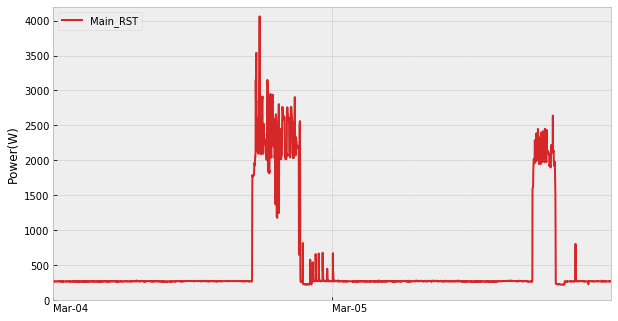

In [4]:
rcParams['figure.figsize'] = (10, 6)

t0='2020-03-04 00:00:00+01:00'
t1='2020-03-05 00:00:00+01:00'
t2='2020-03-06 00:00:00+01:00'

ax1 = next(valid_Main.load(ac_type='active', sample_period=60, resample_kwargs={'how':'first'}))[t0:t2].plot(c='tab:red') 
ax1.legend(['Main_RST'], loc='upper left') #etiquetas
ax1.minorticks_off()
ax1.set(xticks=(t0, t1))
ax1.set_xticklabels(labels=['Mar-04','Mar-05'], ha='left', rotation=0)    
ax1.set_ylabel('Power(W)')
ax1.set_ylim(0,4200)
plt.savefig('C:/data/images/5.1_Plot_valid_main.svg', bbox_inches='tight', transparent=True)
pass

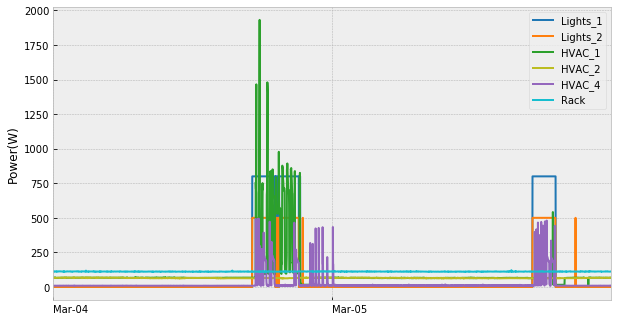

In [5]:
rcParams['figure.figsize'] = (10, 6)

t0='2020-03-04 00:00:00+01:00'
t1='2020-03-05 00:00:00+01:00'
t2='2020-03-06 00:00:00+01:00'

ax2 = valid_Devices.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})[t0:t2].plot()  
#colores
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']
c=0
for col in colors:    
    ax2.get_lines()[c].set_color(col)
    c=c+1   
ax2.legend(list(Meters.values())[4:10])
ax2.minorticks_off()
ax2.set(xticks=(t0, t1))
ax2.set_xticklabels(labels=['Mar-04','Mar-05'], ha='left', rotation=0)    
ax2.set_ylabel('Power(W)')
plt.savefig('C:/data/images/5.2_Plot_valid_devices.svg', bbox_inches='tight', transparent=True)
pass

### Desagregación para validación

La desagregación de los datos de validación se realiza utilizando los datos del MeterGroup valid_Main, el cual contiene el ElecMeter de los datos agregados de las tres fases del sistema eléctrico del Aula 2.2 Bis. Así, el medidor principal Main_RST será el dato de entrada para cada uno de los modelos de desagregación entrenados.

In [6]:
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
periods = {'10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10, '15min':60*15, '30min':60*30}
methods = ['mean', 'median', 'first']
times = {}
for sp_name, sp in periods.items():
    t=[]
    for method in methods:
        models={'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
        for model_name, model in models.items():
            #mod
            model.MIN_CHUNK_LENGTH = 1
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)
            if method=='first':
                model.import_model(data_dir+'NILM/Models/'+model_name+'_1s_'+method+'_model.pickle')
            else:
                model.import_model(data_dir+'NILM/Models/'+model_name+'_'+sp_name+'_'+method+'_model.pickle')
            output=HDFDataStore(data_dir+'NILM/Results/'+model_name+'_'+sp_name+'_'+method+'_pred.h5', 'w')
            import time
            start = time.time()
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            end = time.time()-start
            t.append(round(end,2))     
    times[sp_name] = t

times_v = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean', 'CO_median', 'FHMM_median','CO_first', 'FHMM_first'])

******************** CO 10s mean********************
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])'
Estimating power demand for 'ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)

Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])'
Estimating power demand for 'ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])'
******************** FHMM 10s first********************
******************** CO 30s mean********************
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset

Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])'
Estimating power demand for 'ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6

******************** FHMM 60s median********************
******************** CO 60s first********************
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])'
Estimating power demand for 'ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, datas

Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])'
Estimating power demand for 'ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6

******************** CO 10min median********************
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])'
Estimating power demand for 'ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instanc

Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])'
Estimating power demand for 'ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6

******************** CO 30min mean********************
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])'
Estimating power demand for 'ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=

Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])'
Estimating power demand for 'ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6

In [7]:
times_v.transpose()

,CO_mean,FHMM_mean,CO_median,FHMM_median,CO_first,FHMM_first
10s,0.71,28.02,0.38,10.06,0.42,4.68
30s,0.35,9.09,0.35,2.07,0.40,2.12
60s,0.38,5.08,0.36,1.35,0.39,1.37
5min,0.38,1.62,0.35,0.63,0.38,0.77
10min,0.40,1.13,0.34,0.58,0.36,0.55
15min,0.38,0.91,0.34,0.50,0.35,0.48
30min,0.35,0.75,0.34,0.46,0.33,0.45


## Ejemplo

Se utilizan dos archivos de resultados (CO y FHMM 60s - first) para visualizar las predicciones hechas por los modelos y contrastarlas con las mediciones reales de dispositivos en cada caso

In [8]:
#resultados de predicción modelo CO 60s
CO_60s_first=DataSet(data_dir+'NILM/Results/CO_60s_first_pred.h5')
elec_CO_60s_first=CO_60s_first.buildings[1].elec
#resultados de predicción modelo FHMM 60s
FHMM_60s_first=DataSet(data_dir+'NILM/Results/FHMM_60s_first_pred.h5')
elec_FHMM_60s_first= FHMM_60s_first.buildings[1].elec

Carga de datos de predicciones y GT en memoria

In [9]:
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())
pred_CO=elec_CO_60s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[4:10]
pred_FHMM=elec_FHMM_60s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[4:10]

Gráfico comparativo

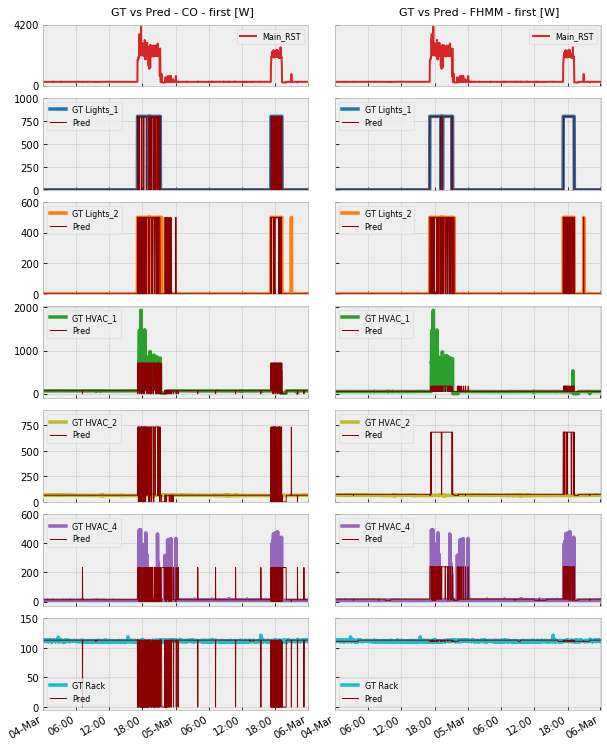

In [10]:
rcParams['figure.figsize'] = (10, 14)

fig, ((ax_a,ax_b),(ax1,ax7),(ax2,ax8),(ax3,ax9),
      (ax4,ax10),(ax5,ax11),(ax6,ax12)) = plt.subplots(7, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3]})

t='60s'; m1='_CO'; m2='_FHMM'; f=8
pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6],[ax_b,ax7,ax8,ax9,ax10,ax11,ax12]]

for i in range(2):

    gt['Main_RST'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main_RST'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Lights_1'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Lights_1'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Lights_1','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Lights_2'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Lights_2'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Lights_2','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['HVAC_1'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['HVAC_1'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT HVAC_1','Pred'], fontsize=f, loc='upper left', ncol=1)

    gt['HVAC_2'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['HVAC_2'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT HVAC_2','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['HVAC_4'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['HVAC_4'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT HVAC_4','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

    gt['Rack'].plot(ax=ax[i][6], lw=3.5, c='tab:cyan')
    pred[i]['Rack'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Rack','Pred'], fontsize=f, loc='lower left', ncol=1)
    ax[i][6].set_ylim(-5,150)
    
    ax[i][6].minorticks_off()
    ax[i][6].set(xticks=['2020-03-04 00:00:00+01:00','2020-03-04 06:00:00+01:00','2020-03-04 12:00:00+01:00',
                        '2020-03-04 18:00:00+01:00','2020-03-05 00:00:00+01:00','2020-03-05 06:00:00+01:00',
                        '2020-03-05 12:00:00+01:00','2020-03-05 18:00:00+01:00','2020-03-05 23:50:00+01:00'])
    ax[i][6].set_xticklabels(labels=['04-Mar','06:00','12:00','18:00','05-Mar','06:00','12:00','18:00','06-Mar'])       

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('C:/data/images/5.3_Plot_valid_60s.svg', bbox_inches='tight', transparent=True)
pass

### Métricas

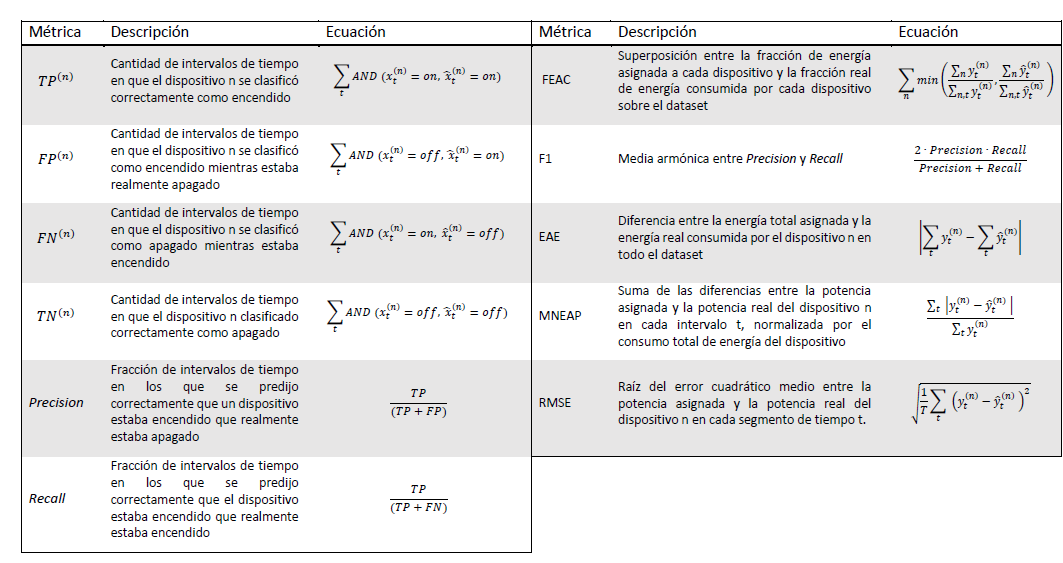

In [11]:
#Librerías
from nilmtk.metrics import f1_score
from nilmtk.metrics import error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power
from nilmtk.metrics import rms_error_power
from nilmtk.metrics import fraction_energy_assigned_correctly

### Métricas individuales del modelo

In [12]:
index = list(labels['Meters'][4:10])
met = []
e = []
#Datos de Dispositivos: predicción
dataset=DataSet(data_dir+'NILM/Results/CO_60s_first_pred.h5')
predictions=dataset.buildings[1].elec.submeters()      
#Metricas
f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {};

f1['F1'] = f1_score(predictions, valid_Devices)

EAE = error_in_assigned_energy(predictions, valid_Devices)
for x in range(len(EAE)): e.append(EAE.iloc[x][0])
eae['EAE'] = e

feac['FEAC'] = np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))

mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)

rmse['RMSE'] = rms_error_power(predictions, valid_Devices)

met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                      pd.DataFrame(f1),
                      pd.DataFrame(eae, index=valid_Devices.instance()),
                      pd.DataFrame(mneap),
                      pd.DataFrame(rmse)],
                     axis=1).set_index(pd.Index(index)))

dataset.store.close()       
print('\n\nDone!')
metrics=met[0].transpose().round(3)
metrics

6/6 ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])

Done!


,Lights_1,Lights_2,HVAC_1,HVAC_2,HVAC_4,Rack
FEAC,0.858,0.858,0.858,0.858,0.858,0.858
F1,0.915,0.860,0.968,0.972,0.463,0.945
EAE,0.608,0.588,1.619,2.556,0.494,0.486
MNEAP,0.155,0.259,0.589,0.937,1.230,0.117
RMSE,108.786,88.876,165.899,193.997,72.463,35.965


Análisis particular del cálculo de cada métrica

FEAC

In [13]:
pd.DataFrame(metrics.loc['FEAC']).transpose()

,Lights_1,Lights_2,HVAC_1,HVAC_2,HVAC_4,Rack
FEAC,0.858,0.858,0.858,0.858,0.858,0.858


6/6 ElecMeter(instance=10, building=1, dataset='CO', appliances=[Appliance(type='server computer', instance=1)])])

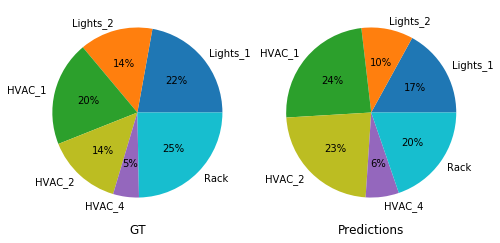

In [14]:
predictions_Devices=elec_CO_60s_first.submeters()
frac_1 = valid_Devices.fraction_per_meter()
frac_2 = predictions_Devices.fraction_per_meter()
fig, (ax1, ax2) = plt.subplots(1, 2 ,gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
frac_1.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',
            labels=list(Meters.values())[4:10], figsize=(8,8), ax=ax1,
            colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan'])
frac_2.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',
            labels=list(Meters.values())[4:10], figsize=(8,8), ax=ax2,
            colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']) 
ax1.set(ylabel="")
ax1.set(xlabel="GT")
ax2.set(ylabel="")
ax2.set(xlabel="Predictions")
plt.savefig('C:/data/images/5.4_FEAC_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

F1

In [15]:
pd.DataFrame(metrics.loc['F1']).transpose()*100

,Lights_1,Lights_2,HVAC_1,HVAC_2,HVAC_4,Rack
F1,91.5,86.0,96.8,97.2,46.3,94.5


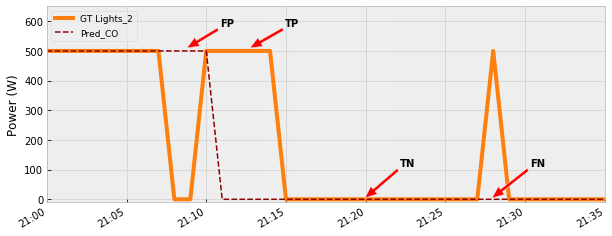

In [16]:
rcParams['figure.figsize'] = (10, 4)
t0='2020-03-04 21:00:00+01:00' #tiempo inicial
t1='2020-03-04 21:35:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['Lights_2'].plot(lw=4, c='tab:orange')
pred_CO['Lights_2'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['GT Lights_2','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,650)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['21:00','21:05','21:10','21:15','21:20','21:25','21:30','21:35']
                    , horizontalalignment ='right')  
ax1.set_ylabel('Power (W)')
ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
ax1.annotate('TN', xy=(365, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
ax1.annotate('FN', xy=(492, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
plt.savefig('C:/data/images/5.5_F1_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

EAE

In [17]:
round(pd.DataFrame(metrics.loc['EAE']).transpose(),2)

,Lights_1,Lights_2,HVAC_1,HVAC_2,HVAC_4,Rack
EAE,0.61,0.59,1.62,2.56,0.49,0.49


In [18]:
e1=predictions_Devices[5].total_energy()[0]
e2=valid_Devices[5].total_energy()[0]
eae=round(abs(e1-e2),2)

pd.DataFrame([e1,e2,eae], columns=['kWh'], index=['Energy_pred','Energy_GT','EAE'])

,kWh
Energy_pred,4.186667
Energy_GT,4.794444
EAE,0.610000


MNEAP

In [19]:
round(pd.DataFrame(metrics.loc['MNEAP']).transpose(),2)

,Lights_1,Lights_2,HVAC_1,HVAC_2,HVAC_4,Rack
MNEAP,0.16,0.26,0.59,0.94,1.23,0.12


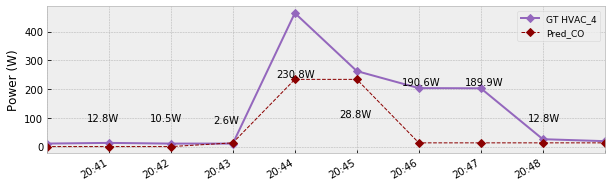

In [20]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();
a1=[1240,1250]
gt['HVAC_4'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['HVAC_4'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")
ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT HVAC_4','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['HVAC_4'][a1[0]:a1[1]]-pred_CO['HVAC_4'][a1[0]:a1[1]])[1:9],1))
aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 30+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1

ax1.set_xticklabels(labels=['','20:41','20:42','20:43','20:44','20:45','20:46','20:47','20:48',''])   
plt.savefig('C:/data/images/5.6_MNEAP_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

RMSE

In [21]:
round(pd.DataFrame(metrics.loc['RMSE']).transpose(),1)

,Lights_1,Lights_2,HVAC_1,HVAC_2,HVAC_4,Rack
RMSE,108.8,88.9,165.9,194.0,72.5,36.0


### Resultados de todos los modelos 

In [22]:
from nilmtk.metrics import fraction_energy_assigned_correctly, f1_score, error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power, rms_error_power 
periods = {'10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10, '15min':60*15, '30min':60*30}

dir_predictions = data_dir +'NILM/Results/'
m = {}
classifiers = ['CO', 'FHMM']
methods = ['first', 'mean', 'median']
index = list(labels['Meters'][4:10])

for p_name, sp in periods.items():
    met = []
    for method in methods:
        for clf_name in classifiers:
            print('\nCalculando Metricas: '+ clf_name + '_' + p_name + '_' + method)  
            #Datos de Dispositivos: predicción
            input_dir = dir_predictions + clf_name + '_' + p_name + '_' + method +'_pred.h5'
            dataset = DataSet(input_dir)
            predictions=dataset.buildings[1].elec.submeters()       
            #Metricas
            f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {}; e=[];  
            F1 = f1_score(predictions, valid_Devices)
            f1['F1'] = F1*100
            EAE = error_in_assigned_energy(predictions, valid_Devices)
            for x in range(len(EAE)): e.append(EAE.iloc[x][0])
            eae['EAE'] = e
            feac['FEAC'] = 100*np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
            mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)
            rmse['RMSE'] = rms_error_power(predictions, valid_Devices)
            met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                                  pd.DataFrame(f1),
                                  pd.DataFrame(eae, index=valid_Devices.instance()),
                                  pd.DataFrame(mneap),
                                  pd.DataFrame(rmse)],
                                 axis=1).set_index(pd.Index(index)))
            dataset.store.close()        
    m[p_name] = met
##Guarda resultados
f = open(data_dir +'NILM/metrics.txt',"w")
f.write( str(m) )
f.close()
print('\n\nDone!')
#m[0] #CO first #m[1] #FHMM first #m[2] #CO mean #m[3] #FHMM mean #m[4] #CO median #m[5] #FHMM median


Calculando Metricas: CO_10s_first
6/6 ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])
Calculando Metricas: FHMM_10s_first
6/6 ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])
Calculando Metricas: CO_10s_mean
6/6 ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])
Calculando Metricas: FHMM_10s_mean
6/6 ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])
Calculando Metricas: CO_10s_median
6/6 ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])
Calculando Metricas: FHMM_10s_median
6/6 ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])
Calculando Metricas: CO_30s_first
6/6 ElecMeter(instance=10, building=1, dataset='DEPS', appliances

#### Metricas promedio 

In [23]:
m_mean = {}

cols=['FEAC','F1','EAE','MNEAP','RMSE']
labels=['CO-first', 'CO-mean', 'CO-median', 'FHMM-first', 'FHMM-mean' ,'FHMM-median']
per=['10s','30s','60s','5min','10min','15min','30min']

for c in cols:
    m_mean[c] = pd.DataFrame([#CO FIRST
                             [m['10s'][0][c].mean(),m['30s'][0][c].mean(),m['60s'][0][c].mean(),
                              m['5min'][0][c].mean(),m['10min'][0][c].mean(),
                              m['15min'][0][c].mean(),m['30min'][0][c].mean()],
                              #CO MEAN
                             [m['10s'][2][c].mean(),m['30s'][2][c].mean(),m['60s'][2][c].mean(),
                              m['5min'][2][c].mean(),m['10min'][2][c].mean(),
                              m['15min'][2][c].mean(),m['30min'][2][c].mean()],
                              #CO MEDIAN
                             [m['10s'][4][c].mean(),m['30s'][4][c].mean(),m['60s'][4][c].mean(),
                              m['5min'][4][c].mean(),m['10min'][4][c].mean(),
                              m['15min'][4][c].mean(),m['30min'][4][c].mean()],
                             #FHMM FIRST
                             [m['10s'][1][c].mean(),m['30s'][1][c].mean(),m['60s'][1][c].mean(),
                             m['5min'][1][c].mean(),m['10min'][1][c].mean(),
                              m['15min'][1][c].mean(),m['30min'][1][c].mean()],
                             #FHMM MEAN            
                             [m['10s'][3][c].mean(),m['30s'][3][c].mean(),m['60s'][3][c].mean(),
                              m['5min'][3][c].mean(),m['10min'][3][c].mean(),
                              m['15min'][3][c].mean(),m['30min'][3][c].mean()],
                             #FHMM MEDIAN
                             [m['10s'][5][c].mean(),m['30s'][5][c].mean(),m['60s'][5][c].mean(),
                              m['5min'][5][c].mean(),m['10min'][5][c].mean(),
                              m['15min'][5][c].mean(),m['30min'][5][c].mean()]],columns=per, index=labels).transpose()

In [24]:
m_mean

{'FEAC':         CO-first    CO-mean  CO-median  FHMM-first  FHMM-mean  FHMM-median
 10s    86.100918  58.910753  64.116577   84.622355  84.701915    85.404505
 30s    85.825478  67.088956  83.839000   84.388587  83.910203    80.739718
 60s    85.794957  69.420333  81.391156   84.241026  82.558227    82.236110
 5min   86.266250  74.085658  61.757435   84.279173  79.249232    79.405344
 10min  88.397590  76.693973  60.656098   84.015260  90.651167    84.019850
 15min  85.967518  76.302356  59.505984   84.556014  88.206824    81.262094
 30min  90.424005  75.589945  63.301740   84.639678  91.710459    97.079318,
 'F1':         CO-first    CO-mean  CO-median  FHMM-first  FHMM-mean  FHMM-median
 10s    85.575528  47.426193  36.748125   87.915127  89.686156    88.902931
 30s    86.568615  59.667228  84.960102   88.890986  90.517673    85.027177
 60s    85.388842  49.691537  81.163025   87.457745  87.119825    86.590520
 5min   80.511017  55.396560  50.540224   82.926722  84.476142    77.7488

#### maximos

In [25]:
cols=['FEAC','F1','EAE','MNEAP','RMSE']

maxs=pd.concat([m_mean['FEAC'].transpose().max(),
                m_mean['F1'].transpose().max(),
                m_mean['EAE'].transpose().min(),
                m_mean['MNEAP'].transpose().min(),
                m_mean['RMSE'].transpose().min()], axis=1)
maxs.columns=cols
maxs = maxs.transpose()
round(maxs,2)

,10s,30s,60s,5min,10min,15min,30min
FEAC,86.10,85.83,85.79,86.27,90.65,88.21,97.08
F1,89.69,90.52,87.46,84.48,86.09,82.01,77.92
EAE,0.92,0.99,1.00,1.00,0.67,0.82,0.19
MNEAP,0.49,0.50,0.54,0.53,0.31,0.37,0.24
RMSE,87.71,91.53,92.15,90.46,64.67,74.93,41.45


Correspondencia de índice

In [26]:
cols=['FEAC','F1','EAE','MNEAP','RMSE']

maxs_i=pd.concat([m_mean['FEAC'].transpose().idxmax(),
                 m_mean['F1'].transpose().idxmax(),
                 m_mean['EAE'].transpose().idxmin(),
                 m_mean['MNEAP'].transpose().idxmin(),
                 m_mean['RMSE'].transpose().idxmin()], axis=1)
maxs_i.columns=cols
maxs_i = maxs_i.transpose()
maxs_i

,10s,30s,60s,5min,10min,15min,30min
FEAC,CO-first,CO-first,CO-first,CO-first,FHMM-mean,FHMM-mean,FHMM-median
F1,FHMM-mean,FHMM-mean,FHMM-first,FHMM-mean,FHMM-mean,FHMM-mean,FHMM-median
EAE,FHMM-median,FHMM-first,FHMM-first,FHMM-first,FHMM-mean,FHMM-mean,FHMM-median
MNEAP,FHMM-median,FHMM-mean,FHMM-first,FHMM-first,FHMM-mean,FHMM-mean,FHMM-median
RMSE,FHMM-median,FHMM-mean,FHMM-first,FHMM-first,FHMM-mean,FHMM-mean,FHMM-median


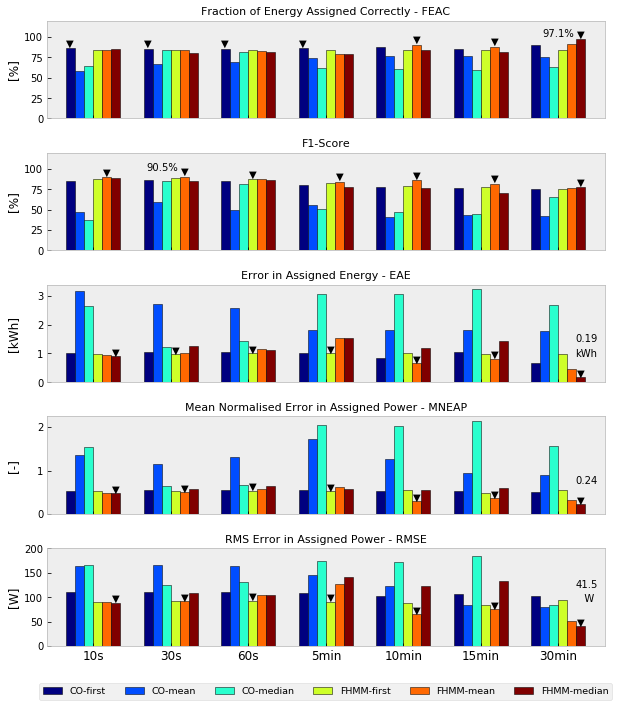

In [37]:
rcParams['figure.figsize'] = (10, 11.5)
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, sharex=True, gridspec_kw={'hspace': 0.35})
cols=['FEAC','F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
per=['10s','30s','60s','5min','10min','15min','30min']

labels={'CO-first':-0.35, 'CO-mean':-0.22, 'CO-median':-0.11, 'FHMM-first':0.01, 'FHMM-mean':0.13 ,'FHMM-median':0.245}

c=0
for ax in fig.get_axes():      
    m_mean[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, cmap="jet")
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    x = 0
    for p in per:
        ax.annotate("▼", xy=(labels[maxs_i[p][cols[c]]]+x, maxs[p][cols[c]]+maxs[p][cols[c]]*0.03))
        x+=1
    c+=1
    
ax5.set_xticklabels(labels=per, rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax1.set(ylim=(0,120))
ax1.set_yticks([0,25,50,75,100])
ax2.set(ylim=(0,120))
ax2.set_yticks([0,25,50,75,100])
ax5.set_yticks([0,50,100,150,200])
ax1.set_title('Fraction of Energy Assigned Correctly - FEAC', fontsize=11, loc='center')
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels.keys(), loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.6),fontsize=9.5)


ax1.annotate("97.1%", xy=(5.8, 100)); #30min FHMM-median
ax2.annotate("90.5%", xy=(0.68, 98)); #30s FHMM-mean
ax3.annotate("0.19", xy=(6.22, 1.4)); #30min FHMM-median
ax3.annotate("kWh", xy=(6.22, 0.9)); #30min FHMM-median
ax4.annotate("0.24", xy=(6.22, 0.7)); #30min FHMM-median
ax5.annotate("41.5", xy=(6.22, 120)); #30min FHMM-median
ax5.annotate("   W", xy=(6.22, 90)); #30min FHMM-median


plt.savefig('C:/data/images/5.7_All_metrics.svg', bbox_inches='tight', transparent=True)

pass

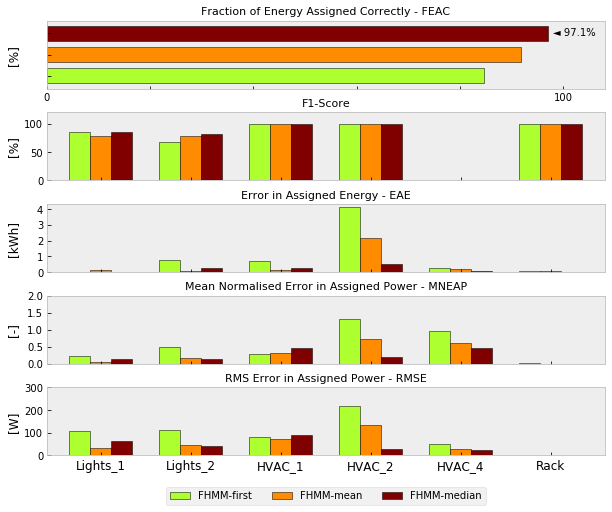

In [59]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, sharex=False, gridspec_kw={'hspace': 0.35})
cols=['FEAC','F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
labels=['FHMM-first', 'FHMM-mean' ,'FHMM-median']
c=0

for ax in fig.get_axes():
    
    df=pd.DataFrame([m['30min'][1][cols[c]],m['30min'][3][cols[c]],m['30min'][5][cols[c]]]).transpose()
    if ax==ax1:
        df['FEAC'].mean().plot.barh(ax=ax1, width=0.7, edgecolor='black', linewidth=0.5, legend=False,
                                    color=['greenyellow','darkorange','maroon'])
    else:
        df.plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False,
                    color=['greenyellow','darkorange','maroon'])
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1   
    
ax1.set_xticklabels(['0','','','','','100'])
ax1.set_yticklabels('')
ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax1.set(xlim=(0,108))
ax2.set(ylim=(0,120))
ax3.set_yticks([0,1,2,3,4])
ax4.set(ylim=(0,1.8))
ax4.set_yticks([0,0.5,1,1.5,2])
ax5.set(ylim=(0,270))
ax5.set_yticks([0,100,200,300])
ax1.set_title('Fraction of Energy Assigned Correctly - FEAC', fontsize=11, loc='center')
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

ax1.annotate("◄ 97.1%", xy=(98, 1.9))

plt.savefig('C:/data/images/5.8_All_metrics_2.svg', bbox_inches='tight', transparent=True)

pass

In [54]:
print('FHMM-first')
print(m['30min'][1])
print('\nFHMM-mean')
print(m['30min'][3])
print('\nFHMM-median')
print(m['30min'][5])

FHMM-first
               FEAC          F1       EAE     MNEAP        RMSE
Lights_1  84.639678   85.714286  0.005556  0.230357  106.706649
Lights_2  84.639678   66.666667  0.763333  0.481365  110.623900
HVAC_1    84.639678  100.000000  0.684661  0.298116   81.391973
HVAC_2    84.639678  100.000000  4.117551  1.328333  219.337493
HVAC_4    84.639678    0.000000  0.224966  0.973034   49.427079
Rack      84.639678  100.000000  0.042371  0.011043    1.416672

FHMM-mean
               FEAC         F1       EAE     MNEAP        RMSE
Lights_1  91.710459   78.26087  0.108444  0.063316   34.971718
Lights_2  91.710459   78.26087  0.037333  0.167116   44.271011
HVAC_1    91.710459  100.00000  0.142161  0.321383   70.542261
HVAC_2    91.710459  100.00000  2.187051  0.717900  134.509280
HVAC_4    91.710459    0.00000  0.191966  0.606937   27.072856
Rack      91.710459  100.00000  0.032871  0.006066    0.771301

FHMM-median
               FEAC          F1       EAE     MNEAP       RMSE
Lights_1  97.

### Resultados del mejor modelo

En vista de los resultados del obtenidos, se propone la elección del modelo FHMM entrenado con datos promedio de dispositivos cada 10 minutos. Este modelo solo se considera adecuado para la desagregación de datos promedio de potencia activa medidos en cabecera cada 10 minutos.

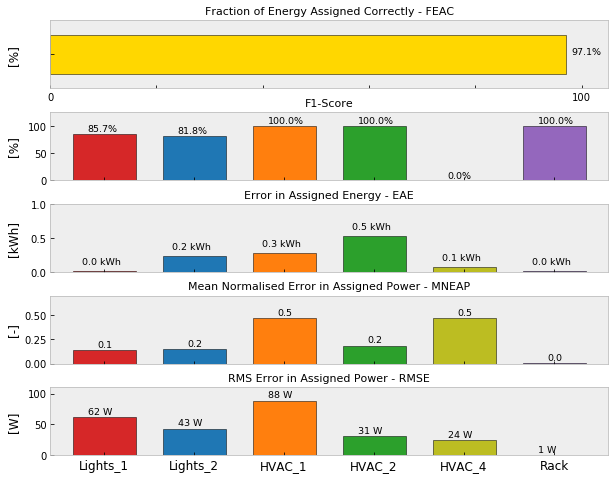

In [65]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, sharex=False, gridspec_kw={'hspace': 0.35})
cols=['FEAC','F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
colors=['tab:red','tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']
c=0

for ax in fig.get_axes():
    df=pd.DataFrame(m['30min'][5][cols[c]])
    if ax==ax1:
        pass
        df.mean().plot.barh(ax=ax1, width=0.7, edgecolor='black', linewidth=0.5, legend=False, color='gold')
    else:
        df[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, color=colors)
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1

ax1.set_xticklabels(['0','','','','','100'])
ax1.set_yticklabels('')
ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax1.set(xlim=(0,105))
ax2.set(ylim=(0,125))
ax3.set(ylim=(0,1))
ax4.set(ylim=(0,0.7))
ax5.set(ylim=(0,110))

#ax2.set_yticks([0,25,50,75,100])
#ax3.set_yticks([0,1,2,3])
#ax4.set_yticks([0,1,2,3,4])
#ax5.set_yticks([0,50,100,150,200])

ax1.set_title('Fraction of Energy Assigned Correctly - FEAC', fontsize=11, loc='center')
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')

df=pd.DataFrame(m['30min'][5])
ax1.annotate(str(round(df['FEAC'][3],1))+'%', xy=(df['FEAC'][0]+1 , 0.01), fontsize=9.5)
for x in range(6):ax2.annotate(str(round(df['F1'][x],1))+'%', xy=(x-0.18 , df['F1'][x]+4),fontsize=9.5)
for x in range(6):ax3.annotate(str(round(df['EAE'][x],1))+' kWh', xy=(x-0.25 , df['EAE'][x]+0.1),fontsize=9.5)
for x in range(6):ax4.annotate(str(round(df['MNEAP'][x],1)), xy=(x-0.08 , df['MNEAP'][x]+0.03),fontsize=9.5)
for x in range(6):ax5.annotate(str(round(df['RMSE'][x]))+' W', xy=(x-0.18 , df['RMSE'][x]+5),fontsize=9.5)

plt.savefig('C:/data/images/5.9_Metrics_FHMM_30min_median.svg', bbox_inches='tight', transparent=True)
pass

In [67]:
valid_Devices.total_energy()

Calculating total_energy for ElecMeterID(instance=10, building=1, dataset='DEPS') ...   

active    21.635551
dtype: float64

In [68]:
valid_Devices.energy_per_meter()

6/6 ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])

,"(5, 1, DEPS)","(6, 1, DEPS)","(7, 1, DEPS)","(8, 1, DEPS)","(9, 1, DEPS)","(10, 1, DEPS)"
active,4.794444,3.013333,4.313661,3.108949,1.062034,5.343129
apparent,NaN,NaN,NaN,NaN,NaN,NaN
reactive,NaN,NaN,NaN,NaN,NaN,NaN


## Replicando el entrenamiento del modelo

In [80]:
from nilmtk import DataSet
from nilmtk.legacy.disaggregate import FHMM

train=DataSet('C:/data/DEPS.h5')
train.set_window(start="2020-02-25 00:00:00", end="2020-03-03 23:59:59")
train_elec=train.buildings[1].elec 

#dispositivos a entrenar: [Lights_1, Lights_2, HVAC_1, HVAC_2, HVAC_4, Rack]
train_Devices=train_elec.select(instance=[5,6,7,8,9,10])

#opcional: asignación manual de estados de dispositivos
num_states={train_Devices[5]:2, train_Devices[6]:2, train_Devices[7]:3,
            train_Devices[8]:3, train_Devices[9]:3, train_Devices[10]:3}

#entrenamiento y exportación del modelo
FHMM_30min_median=FHMM()
FHMM_30min_median.MIN_CHUNK_LENGTH=1
FHMM_30min_median.train(train_Devices,
                        num_states_dict={}, #en otro caso: { }
                        ac_type='active',
                        sample_period=1800,
                        resample_kwargs={'how':'median'})

FHMM_30min_median.export_model('C:/data/FHMM_30min_median_model.pickle') 

Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])' with 2 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])' with 2 states
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])' with 3 states
Training model for submeter 'ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])' with 3 states


### Examinando el modelo

In [92]:
from nilmtk.legacy.disaggregate import FHMM
FHMM=FHMM()
FHMM.import_model('C:/data/FHMM_30min_median_model.pickle') 
print(type(FHMM.individual[valid_Devices[5]].means_))
print('Lights_1: '+str(FHMM.individual[valid_Devices[5]].means_))
print('Lights_1: '+str(FHMM.individual[valid_Devices[6]].means_))
print('HVAC_1: '+str(FHMM.individual[valid_Devices[7]].means_))
print('HVAC_2: '+str(FHMM.individual[valid_Devices[8]].means_))
print('HVAC_4: '+str(FHMM.individual[valid_Devices[9]].means_))
print('Rack: '+str(FHMM.individual[valid_Devices[10]].means_))

<class 'numpy.ndarray'>
Lights_1: [[  0.]
 [800.]]
Lights_1: [[  0.]
 [500.]]
HVAC_1: [[ 15.86999989]
 [ 71.14399609]
 [100.31666819]]
HVAC_2: [[ 65.43572869]
 [108.71499884]
 [172.875     ]]
HVAC_4: [[  9.14519606]
 [ 10.53669555]
 [101.7922616 ]]
Rack: [[110.84580048]
 [111.48306179]
 [112.09999847]]


In [93]:
FHMM.model

GaussianHMM(covariance_type='full', n_components=324)

In [94]:
FHMM.individual

OrderedDict([(ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)]),
              GaussianHMM(covariance_type='full', n_components=2)),
             (ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)]),
              GaussianHMM(covariance_type='full', n_components=2)),
             (ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)]),
              GaussianHMM(covariance_type='full', n_components=3)),
             (ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)]),
              GaussianHMM(covariance_type='full', n_components=3)),
             (ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)]),
              GaussianHMM(covariance_type='full', n_components=3)),
             (ElecMeter(instance=10, building=1, datase